In [1]:
import os, json, sys, pickle, xmltodict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Set up

Extracting symptoms associated with each Orphanet diseases and very frequent symptoms only: 

In [ ]:
# convert the XML file to a dictionary
file_path = os.path.expanduser('~/scratch-llm/data/Orphanet/Orphanet_HPO.xml') #diseases with HPO symptoms
with open(file_path, 'r', encoding='latin-1') as file:
    xml_content = file.read()
orpha_data = xmltodict.parse(xml_content)

# Obtain a list of very frequent symptoms from each disease in Orphanet
orpha_frequent = {}
orpha_all = {}
for status in orpha_data['JDBOR']['HPODisorderSetStatusList']['HPODisorderSetStatus']:
    disorder = status['Disorder']
    name = disorder['Name']['#text']
    orpha_all[name] = []
    orpha_frequent[name] = []
    hpo_assoc_list = disorder.get('HPODisorderAssociationList', {}).get('HPODisorderAssociation', [])
    #print(f"Processing disorder: {name}")
    if isinstance(hpo_assoc_list, dict):
        hpo_assoc_list = [hpo_assoc_list]
    for assoc in hpo_assoc_list:
        freq = assoc.get('HPOFrequency', {}).get('Name', {}).get('#text', '')
        if freq == 'Very frequent (99-80%)' or freq == 'Obligate (100%)': # very frequent includes "diagnostic criterion" and "pathognomonic" symptoms + some others
            hpo_name = assoc.get('HPO', {}).get('HPOTerm', '')
            orpha_frequent[name].append(hpo_name)
            # print(f"\t {hpo_name} ({freq})")
        hpo_name = assoc.get('HPO', {}).get('HPOTerm', '')
        orpha_all[name].append(hpo_name)

# save to json file
orpha_frequent_file = os.path.expanduser('~/scratch-llm/data/Orphanet/orphanet_frequent.json')
with open(orpha_frequent_file, 'w') as f:
    json.dump(orpha_frequent, f, indent=4)

orpha_all_file = os.path.expanduser('~/scratch-llm/data/Orphanet/orphanet_all.json')
with open(orpha_all_file, 'w') as f:
    json.dump(orpha_all, f, indent=4)

## Datasets

### Phenopackets results

In [52]:
# load Phenopacket results data
pp_results = os.path.expanduser('~/scratch-llm/results/disease_mode/evaluation/phenopackets_diseases_results.csv')
with open(pp_results, 'r') as f:
    pp_results = pd.read_csv(f)

### Orphanet results, all and very frequent

In [53]:
# load Orphanet results data
orpha_results = os.path.expanduser('~/scratch-llm/results/disease_mode/evaluation/orphanet_all_results.csv')
with open(orpha_results, 'r') as f:
    orpha_all_results = pd.read_csv(f)

In [54]:
orpha_results = os.path.expanduser('~/scratch-llm/results/disease_mode/evaluation/orphanet_frequent_results.csv')
with open(orpha_results, 'r') as f:
    orpha_freq_results = pd.read_csv(f)

# Data analysis

## Orphanet all symptoms

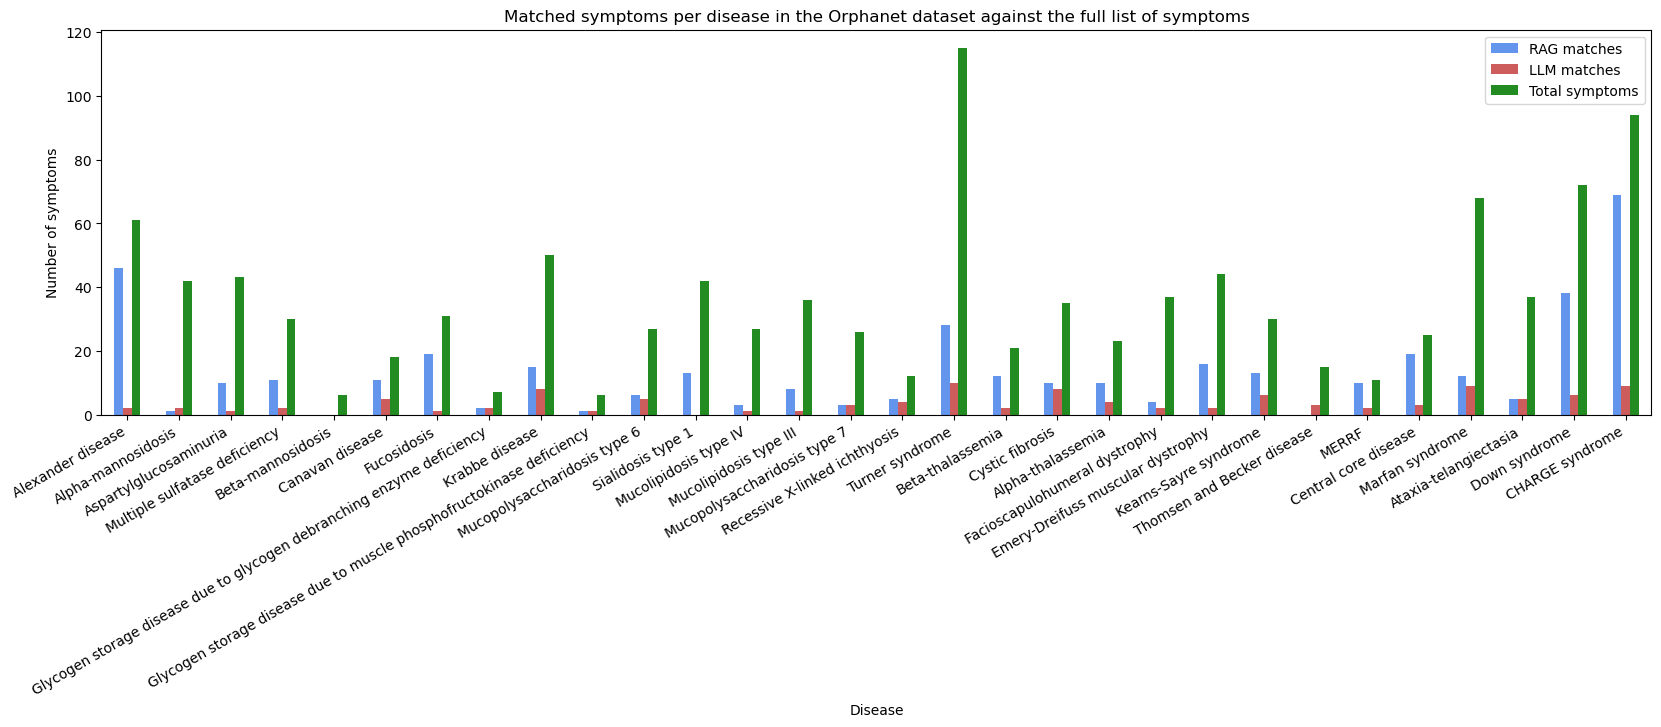

In [55]:
orpha_all_results[:30].plot(
    x="disease",
    y=["rag_matches", "no_rag_matches", "total_symptoms"],
    kind="bar",
    color=["cornflowerblue", "indianred", "forestgreen"],
    title="Matched symptoms per disease in the Orphanet dataset against the full list of symptoms",
    ylabel="Number of symptoms",
    xlabel="Disease",
    figsize=(20, 5),
)
plt.xticks(rotation=30, ha='right')
plt.legend(["RAG matches", "LLM matches", "Total symptoms"])
plt.show()

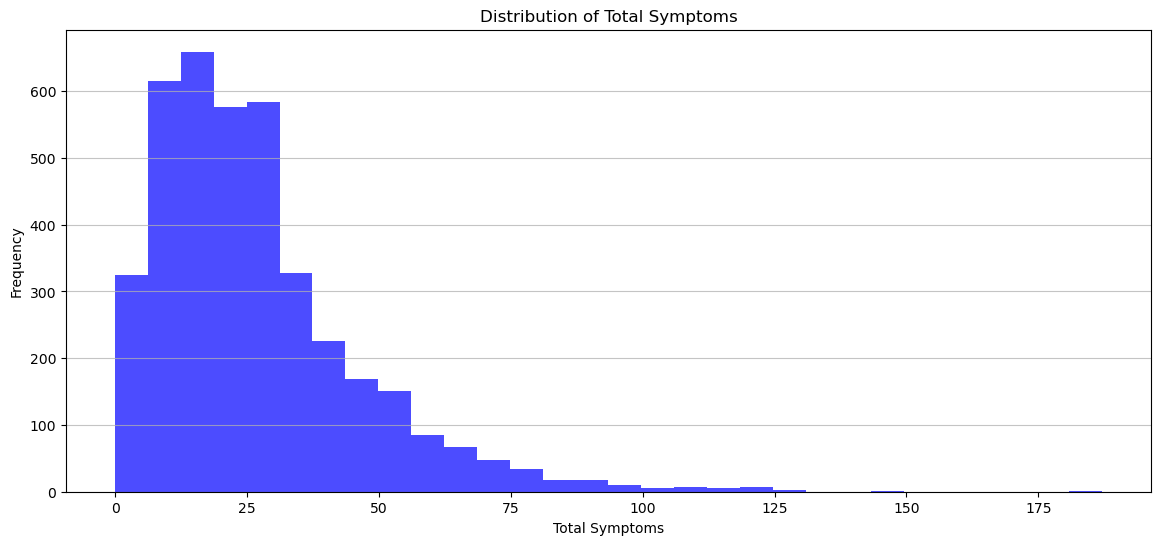

Mean number of symptoms: 27.0 
Most symptoms: 187 
Less symptoms: 0


In [75]:
plt.figure(figsize=(14, 6))
plt.hist(orpha_all_results['total_symptoms'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Total Symptoms')
plt.xlabel('Total Symptoms')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

#mean number of symptoms
mean_symptoms = orpha_all_results['total_symptoms'].mean()
print(f"Mean number of symptoms: {round(mean_symptoms,0)} \nMost symptoms: {orpha_all_results['total_symptoms'].max()} \nLess symptoms: {orpha_all_results['total_symptoms'].min()}")

In [57]:
# calculate the percentage of RAG vs No-RAG matches across all diseases
rag_matches_percentage_all = orpha_all_results['rag_matches'].sum() / orpha_all_results['total_symptoms'].sum() * 100 
no_rag_matches_percentage_all = orpha_all_results['no_rag_matches'].sum() / orpha_all_results['total_symptoms'].sum() * 100
print(f"RAG matches: {round(rag_matches_percentage_all, 2)}% ({round(orpha_all_results['rag_matches'].mean(),0)} symptoms) \nLLM matches: {round(no_rag_matches_percentage_all, 2)}% ({round(orpha_all_results['no_rag_matches'].mean(),0)} symptoms)")


RAG matches: 42.08% (11.0 symptoms) 
LLM matches: 11.15% (3.0 symptoms)


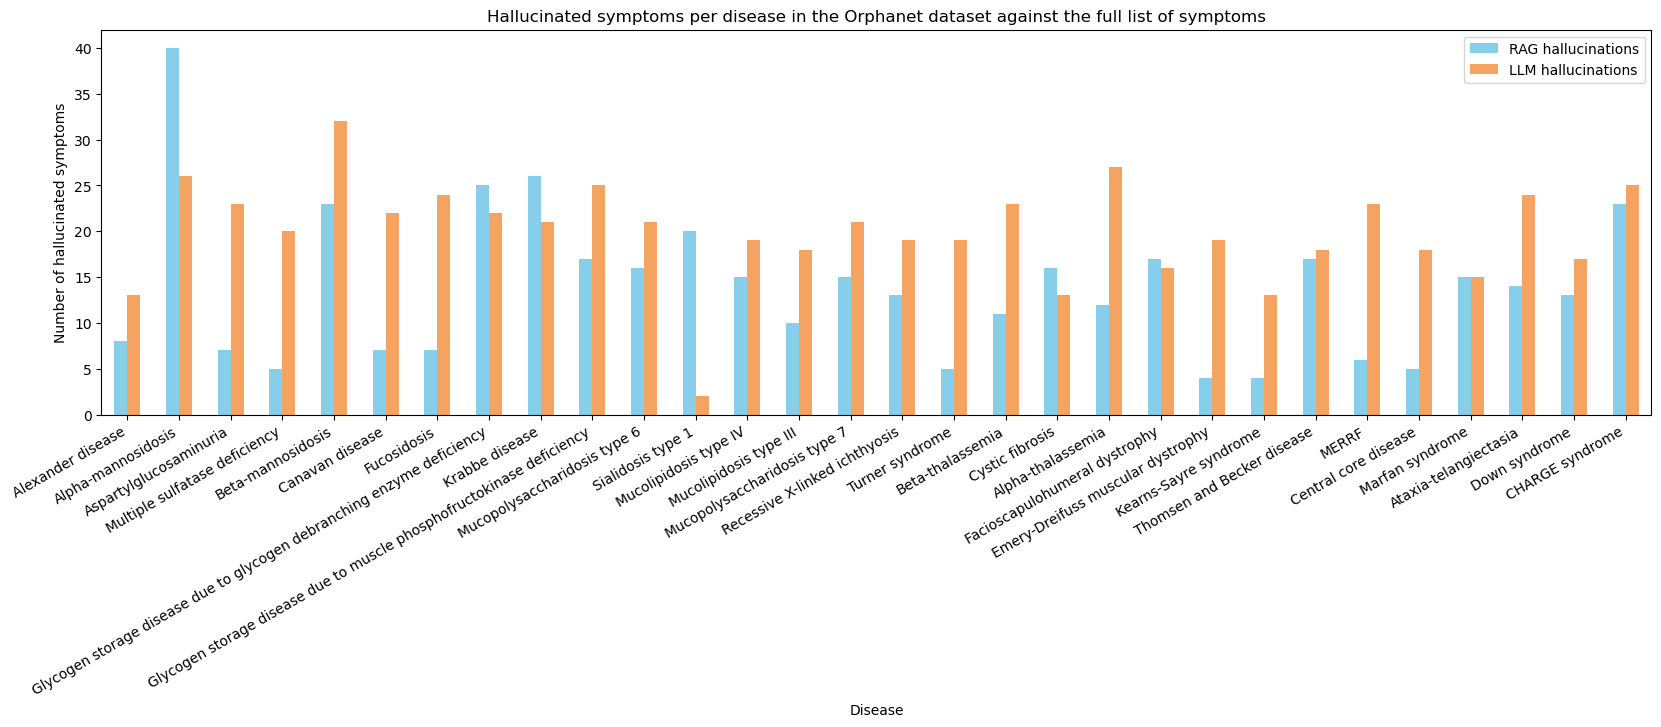

In [58]:
orpha_all_results[:30].plot(
    x="disease",
    y=["rag_hallucinations", "no_rag_hallucinations"],#, "total_symptoms"],
    kind="bar",
    color=["skyblue", "sandybrown", "forestgreen"],
    title="Hallucinated symptoms per disease in the Orphanet dataset against the full list of symptoms",
    ylabel="Number of hallucinated symptoms",
    xlabel="Disease",
    figsize=(20, 5),
)
plt.xticks(rotation=30, ha='right')
plt.legend(["RAG hallucinations", "LLM hallucinations", "Total symptoms"], loc="best")
plt.show()

In [59]:
# average hallucinated symptoms generated
print(f"RAG hallucinations: {round(orpha_all_results['rag_hallucinations'].mean(), 0)} symptoms\nLLM hallucinations: {round(orpha_all_results['no_rag_hallucinations'].mean(), 0)} symptoms")

RAG hallucinations: 13.0 symptoms
LLM hallucinations: 22.0 symptoms


### RAG context influence evaluation

RAG might receive 3 different types of context: <br>
&nbsp;&nbsp; a. Associated text from nodes <br>
&nbsp;&nbsp; b. List of HPO symptoms from the top_node <br>
&nbsp;&nbsp; c. Both together

In [60]:
#load all_nodes
all_nodes_file = os.path.expanduser('~/scratch-llm/storage/nodes/all_nodes.pkl')
with open(all_nodes_file, 'rb') as f:
    all_nodes = pickle.load(f)


In [61]:
# Create three lists to store the subsets
text_only = []
relations_only = []
text_and_relations = []
neither = []

# Iterate through orpha_all_results
for index, row in tqdm(orpha_all_results.iterrows(), desc="Processing Orphanet results"):
    top_node_id = row['rag_top_node_id']

    # Skip if no top_node_id or if it's NaN
    if pd.isna(top_node_id) or top_node_id is None:
        continue

    for i, node in enumerate(all_nodes):
        # find node_index
        if hasattr(node, 'metadata') and 'node_index' in node.metadata:
            if node.metadata['node_index'] == str(top_node_id):
                all_node_index = i
            
    # Find the 'top_node_id' in all_nodes
    node = all_nodes[all_node_index]
    # print(f"\nThe disease from Orphanet: {row['disease']} retrieved the following node from the graph")
    # print(f"Disease name: {node.metadata['node_name']} | ID: {node.metadata['node_index']} | index: {all_node_index}")
    # print(f"{node.text if hasattr(node, 'text') else 'No text'}")
    has_relations = False
    if hasattr(node, 'relationships'):
        for rel_type, rel_nodes in node.relationships.items():
            for rel in rel_nodes:
                if rel.metadata.get('relation') == 'disease_phenotype_positive':
                    # print(f"Phenotypes")
                    has_relations = True
                    break
            if has_relations:
                break

    # Check if node.text is not empty
    has_text = False
    if hasattr(node, 'text') and node.text is not None and not node.text.strip() != '':
        has_text = False
        # if text is false, check for text in nodes connected to it through disease-disease edges
        for rel_type, rel_nodes in node.relationships.items():
            for rel in rel_nodes:
                if rel.metadata.get('relation') == 'disease_disease':
                    # print(f"connected to: {rel.node_id}")
                    for i, node in enumerate(all_nodes):
                        if hasattr(node, 'metadata') and 'node_index' in node.metadata:
                            if node.metadata['node_index'] == str(rel.node_id):
                                # print(f"Found connected node: {node.metadata['node_name']} | ID: {node.metadata['node_index']} | text: {node.text}")
                                has_text = True # if one of the associated nodes has text break
                                break
                    
            if has_text:
                break
    else:
        has_text = True

    # Categorize based on what the node has
    disease_name = row #remove diseases

    if has_text and has_relations:
        text_and_relations.append(disease_name)
    elif has_text and not has_relations:
        text_only.append(disease_name)
    elif not has_text and has_relations:
        relations_only.append(disease_name)
    else:
        neither.append(disease_name)


text_only = pd.DataFrame(text_only)
relations_only = pd.DataFrame(relations_only)
text_and_relations = pd.DataFrame(text_and_relations)

print(f"\n\nDiseases with text only: {len(text_only)}")
print(f"Diseases with relations only: {len(relations_only)}")
print(f"Diseases with both text and relations: {len(text_and_relations)}")
print(f"Diseases with neither text nor relations: {len(neither)}")

avg_text_only = round(text_only['rag_matches'].sum() / text_only['total_symptoms'].sum() * 100, 2)
avg_relations_only = round(relations_only['rag_matches'].sum() / relations_only['total_symptoms'].sum() * 100, 2)
avg_text_and_relations = round(text_and_relations['rag_matches'].sum() / text_and_relations['total_symptoms'].sum() * 100, 2)


Processing Orphanet results: 3941it [08:09,  8.04it/s]



Diseases with text only: 532
Diseases with relations only: 2
Diseases with both text and relations: 3407
Diseases with neither text nor relations: 0


In [62]:
# input retrieves a node, how is that node:
disease_counts = pd.DataFrame({
    'Category': ['Text only', 'Phenotypes only', 'Text and phenotypes'],
    'Number of diseases': [len(text_only), len(relations_only), len(text_and_relations)],
    'Percentage matches': [f"{avg_text_only} %", f"{avg_relations_only} %", f"{avg_text_and_relations} %"]
})
disease_counts

,Category,Number of diseases,Percentage matches
0,Text only,532,11.97 %
1,Phenotypes only,2,31.46 %
2,Text and phenotypes,3407,46.67 %


## Orphanet very frequent/obligate

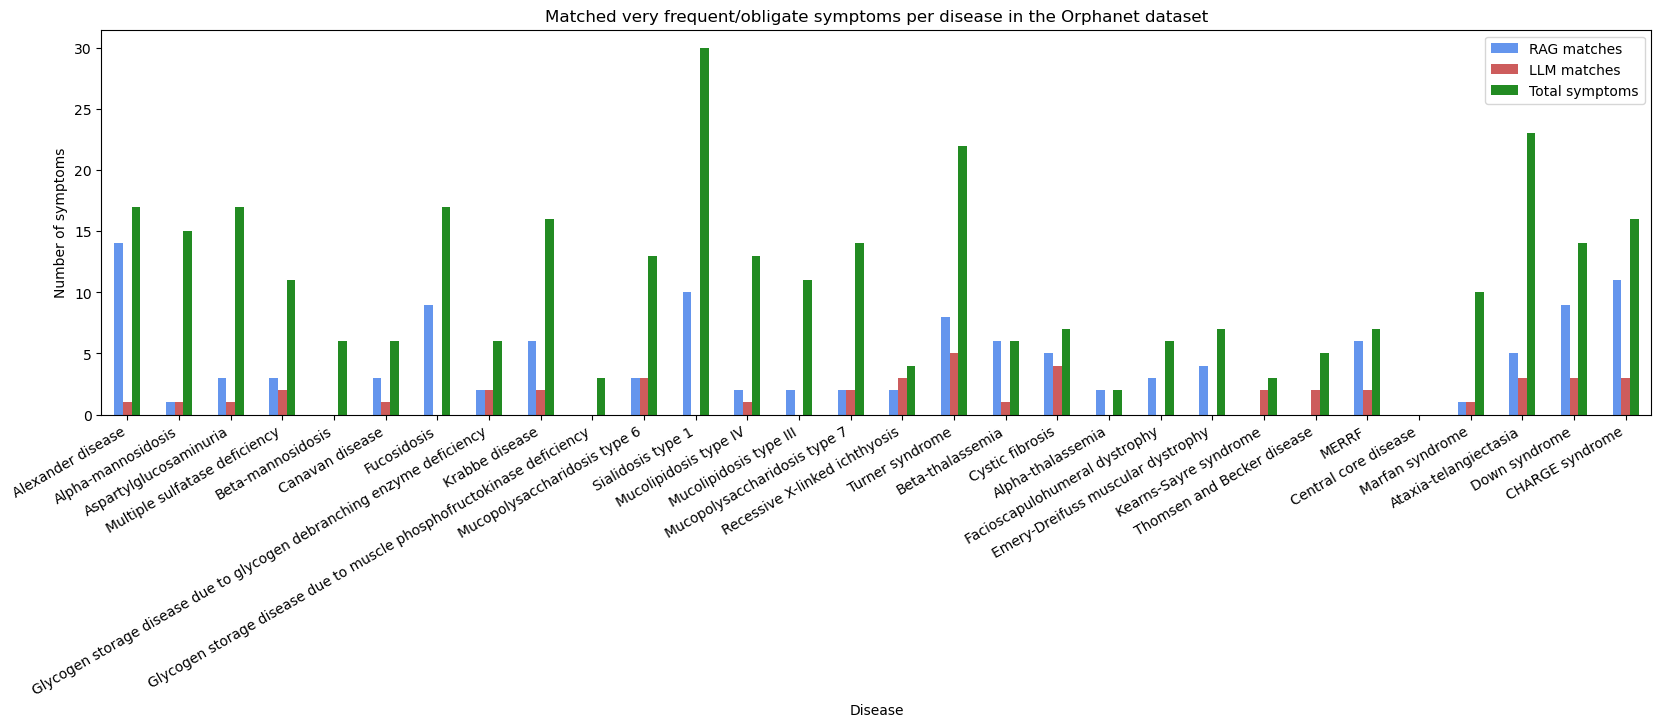

In [63]:
# orpha_freq_results 
orpha_freq_results[:30].plot(
    x="disease",
    y=["rag_matches", "no_rag_matches", "total_symptoms"],
    kind="bar",
    color=["cornflowerblue", "indianred", "forestgreen"],
    title="Matched very frequent/obligate symptoms per disease in the Orphanet dataset",
    ylabel="Number of symptoms",
    xlabel="Disease",
    figsize=(20, 5),
)
plt.xticks(rotation=30, ha='right')
plt.legend(["RAG matches", "LLM matches", "Total symptoms"])
plt.show()

In [64]:
# % of symptoms matched for the freq 
rag_matches_percentage_freq = orpha_freq_results['rag_matches'].sum() / orpha_freq_results['total_symptoms'].sum() * 100 if orpha_freq_results['total_symptoms'].sum() > 0 else 0
no_rag_matches_percentage_freq = orpha_freq_results['no_rag_matches'].sum() / orpha_freq_results['total_symptoms'].sum() * 100 if orpha_freq_results['total_symptoms'].sum() > 0 else 0
print(f"RAG matches percentage: {round(rag_matches_percentage_freq, 2)}% ({round(orpha_freq_results['rag_matches'].mean(), 0)} symptoms) \nLLM matches percentage: {round(no_rag_matches_percentage_freq, 2)}% ({round(orpha_freq_results['no_rag_matches'].mean(), 0)} symptoms)")

#number of hallucinations
print(f"RAG hallucinations: {round(orpha_freq_results['rag_hallucinations'].mean(), 0)} symptoms \nLLM hallucinations: {round( orpha_freq_results['no_rag_hallucinations'].mean(), 0)} symptoms")

RAG matches percentage: 55.83% (3.0 symptoms) 
LLM matches percentage: 16.78% (1.0 symptoms)
RAG hallucinations: 21.0 symptoms 
LLM hallucinations: 24.0 symptoms


## Phenopackets

real patient data, symptoms might also not be related to the condition

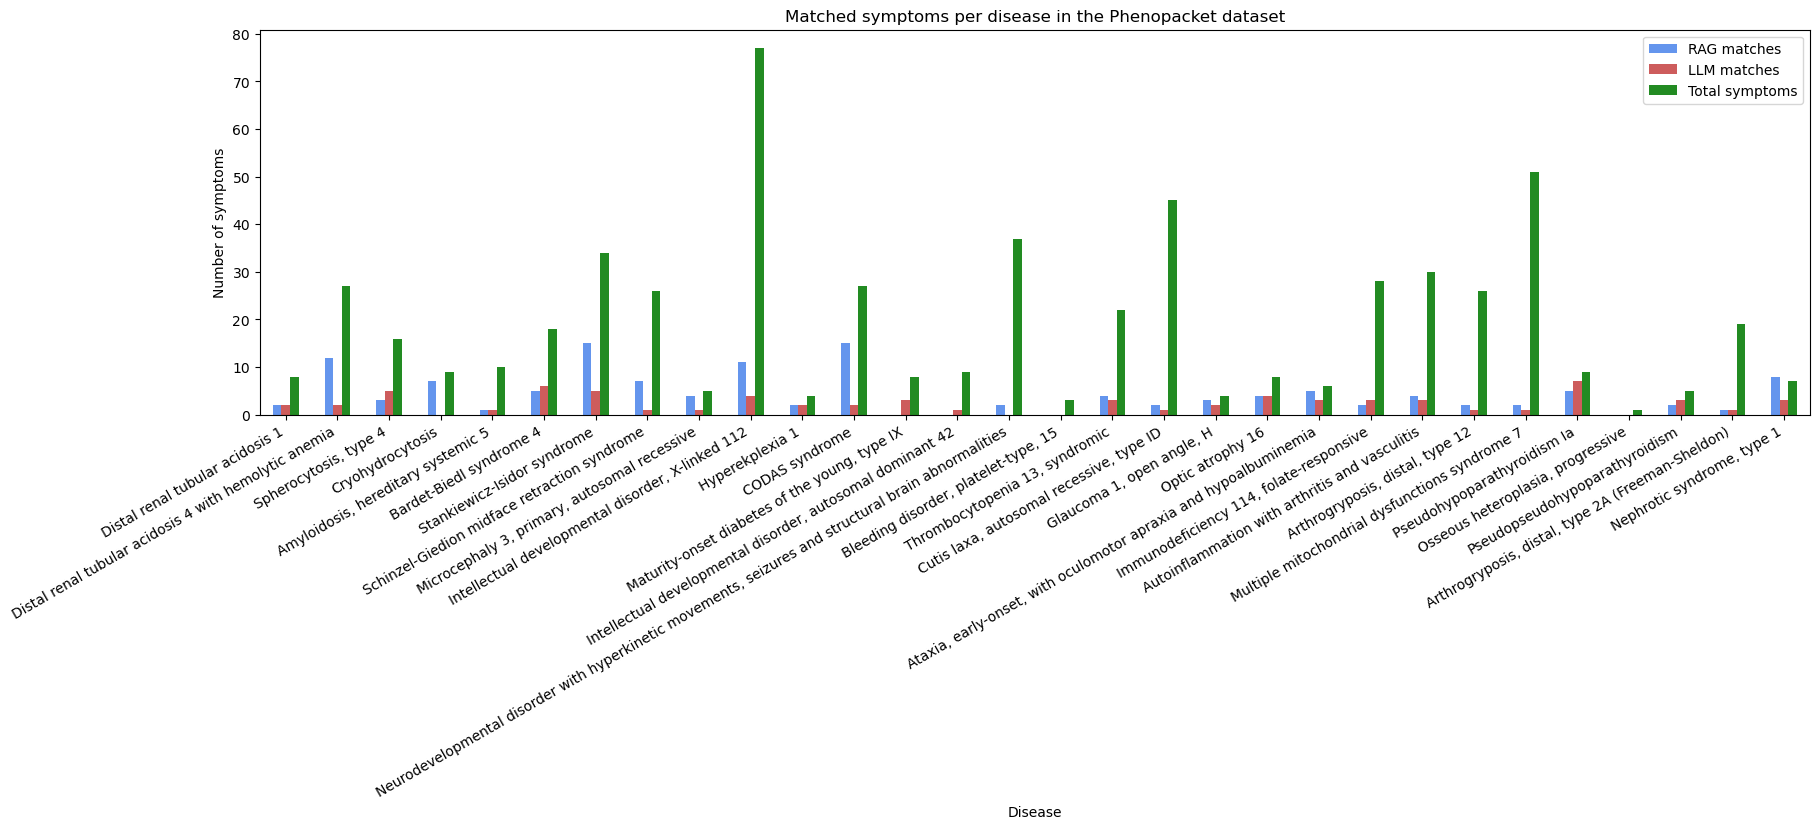

In [65]:
pp_results[20:50].plot(
    x="disease",
    y=["rag_matches", "no_rag_matches", "total_symptoms"],
    kind="bar",
    color=["cornflowerblue", "indianred", "forestgreen"],
    title="Matched symptoms per disease in the Phenopacket dataset",
    ylabel="Number of symptoms",
    xlabel="Disease",
    figsize=(20, 5),
)
plt.xticks(rotation=30, ha='right')
plt.legend(["RAG matches", "LLM matches", "Total symptoms"])
plt.show()

In [66]:
rag_matches_percentage_pp = pp_results['rag_matches'].sum() / pp_results['total_symptoms'].sum() * 100 if pp_results['total_symptoms'].sum() > 0 else 0
no_rag_matches_percentage_pp = pp_results['no_rag_matches'].sum() / pp_results['total_symptoms'].sum() * 100 if pp_results['total_symptoms'].sum() > 0 else 0
print(f"RAG matches {round(rag_matches_percentage_pp,2)}% ({round(pp_results['rag_matches'].mean(),0)} symptoms)")
print(f"LLM matches {round(no_rag_matches_percentage_pp,2)}% ({round(pp_results['no_rag_matches'].mean(),0)} symptoms)")
print(f"\nRAG hallucinations: {round(pp_results['rag_hallucinations'].mean(), 0)} symptoms\nNo RAG hallucinations: {round(pp_results['no_rag_hallucinations'].mean(), 0)} symptoms")

RAG matches 16.74% (5.0 symptoms)
LLM matches 8.92% (3.0 symptoms)

RAG hallucinations: 26.0 symptoms
No RAG hallucinations: 29.0 symptoms


In [67]:
#make a df with all of the percentages
summary_df = pd.DataFrame({
    "Category": ["RAG", "LLM"],
    "Orphanet (all symptoms)": [f"{round(rag_matches_percentage_all, 2)} %", f"{round(no_rag_matches_percentage_all, 2)} %"],
    "Orphanet (very frequent)": [f"{round(rag_matches_percentage_freq, 2)} %", f"{round(no_rag_matches_percentage_freq, 2)} %"],
    "Phenopackets": [f"{round(rag_matches_percentage_pp, 2)} %", f"{round(no_rag_matches_percentage_pp, 2)} %"],
})
summary_df


,Category,Orphanet (all symptoms),Orphanet (very frequent),Phenopackets
0,RAG,42.08 %,55.83 %,16.74 %
1,LLM,11.15 %,16.78 %,8.92 %


In [68]:
print(f"Out of 4282 diseases in Orphanet, RAG and LLM generated a response for {len(orpha_all_results)} diseases.")
print(f"Out of 516 diseases in the Phenopackets, RAG and LLM generated a response for {len(pp_results)} diseases.")

Out of 4282 diseases in Orphanet, RAG and LLM generated a response for 3941 diseases.
Out of 516 diseases in the Phenopackets, RAG and LLM generated a response for 471 diseases.


## Other metrics

### percentage of diseases with more rag / noRAG matches

In [69]:
# count the percentage of diseases with more rag matches, no_rag matches, and equal matches from the results
pp_more_rag = round((pp_results['rag_matches'] > pp_results['no_rag_matches']).sum() / len(pp_results) * 100, 2)
pp_more_no_rag = round((pp_results['no_rag_matches'] > pp_results['rag_matches']).sum() / len(pp_results) * 100, 2)
pp_equal_matches = round((pp_results['rag_matches'] == pp_results['no_rag_matches']).sum() / len(pp_results) * 100, 2)

all_rag_more = round((orpha_all_results['rag_matches'] > orpha_all_results['no_rag_matches']).sum() / len(orpha_all_results) * 100, 2)
all_no_rag_more = round((orpha_all_results['no_rag_matches'] > orpha_all_results['rag_matches']).sum() / len(orpha_all_results) * 100, 2)
all_equal_matches = round((orpha_all_results['rag_matches'] == orpha_all_results['no_rag_matches']).sum() / len(orpha_all_results) * 100, 2)

freq_rag_more = round((orpha_freq_results['rag_matches'] > orpha_freq_results['no_rag_matches']).sum() / len(orpha_freq_results) * 100, 2)
freq_no_rag_more = round((orpha_freq_results['no_rag_matches'] > orpha_freq_results['rag_matches']).sum() / len(orpha_freq_results) * 100, 2)
freq_equal_matches = round((orpha_freq_results['rag_matches'] == orpha_freq_results['no_rag_matches']).sum() / len(orpha_freq_results) * 100, 2)

results_table = pd.DataFrame({
    "Diseases with:": ["RAG > No-RAG", "No-RAG > RAG ", "Equal matches"],
    "Orphanet (all symptoms)": [f"{all_rag_more} %", f"{all_no_rag_more} %", f"{all_equal_matches} %"],
    "Orphanet (very frequent)": [f"{freq_rag_more} %", f"{freq_no_rag_more} %", f"{freq_equal_matches} %"],
    "Phenopackets": [f"{pp_more_rag} %", f"{pp_more_no_rag} %", f"{pp_equal_matches} %"],

})
results_table

,Diseases with:,Orphanet (all symptoms),Orphanet (very frequent),Phenopackets
0,RAG > No-RAG,80.77 %,58.84 %,57.96 %
1,No-RAG > RAG,10.4 %,7.51 %,21.02 %
2,Equal matches,8.83 %,33.65 %,21.02 %


### F1 / Recall / Precision

Text(0.5, 1.0, 'F1 Score distribution for the the Orphanet dataset')

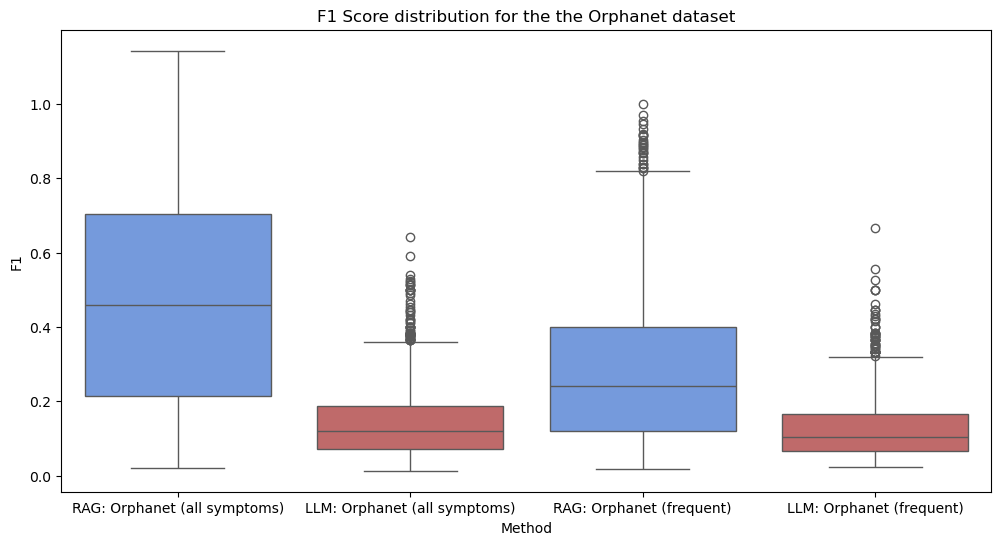

In [70]:
import seaborn as sns

orpha_all_rag_f1 = orpha_all_results['rag_precision'] * orpha_all_results['rag_recall'] / (orpha_all_results['rag_precision'] + orpha_all_results['rag_recall']).replace(0, np.nan) * 2
orpha_all_nonrag_f1 = orpha_all_results['no_rag_precision'] * orpha_all_results['no_rag_recall'] / (orpha_all_results['no_rag_precision'] + orpha_all_results['no_rag_recall']).replace(0, np.nan) * 2

orpha_freq_rag_f1 = orpha_freq_results['rag_precision'] * orpha_freq_results['rag_recall'] / (orpha_freq_results['rag_precision'] + orpha_freq_results['rag_recall']).replace(0, np.nan) * 2
orpha_freq_nonrag_f1 = orpha_freq_results['no_rag_precision'] * orpha_freq_results['no_rag_recall'] / (orpha_freq_results['no_rag_precision'] + orpha_freq_results['no_rag_recall']).replace(0, np.nan) * 2

pp_rag_f1 = pp_results['rag_precision'] * pp_results['rag_recall'] / (pp_results['rag_precision'] + pp_results['rag_recall']).replace(0, np.nan) * 2
pp_nonrag_f1 = pp_results['no_rag_precision'] * pp_results['no_rag_recall'] / (pp_results['no_rag_precision'] + pp_results['no_rag_recall']).replace(0, np.nan) * 2

# create a DataFrame for F1 scores
f1_df = pd.DataFrame({
	'F1': pd.concat([orpha_all_rag_f1, orpha_all_nonrag_f1, orpha_freq_rag_f1, orpha_freq_nonrag_f1], ignore_index=True),
	'Method': ['RAG: Orphanet (all symptoms)'] * len(orpha_all_rag_f1) + ['LLM: Orphanet (all symptoms)'] * len(orpha_all_nonrag_f1) +
			  ['RAG: Orphanet (frequent)'] * len(orpha_freq_rag_f1) + ['LLM: Orphanet (frequent)'] * len(orpha_freq_nonrag_f1)
})

plt.figure(figsize=(12, 6))
sns.boxplot(x='Method', y='F1', hue='Method', data=f1_df, legend=False,
            palette={'RAG: Orphanet (all symptoms)': 'cornflowerblue', 'LLM: Orphanet (all symptoms)': 'indianred',
                     'RAG: Orphanet (frequent)': 'cornflowerblue', 'LLM: Orphanet (frequent)': 'indianred'})
plt.title("F1 Score distribution for the the Orphanet dataset")

In [71]:
# make a table with precision, recall, and F1 scores for both pp_results and orpha_results
precision_recall_f1 = pd.DataFrame({
    "Dataset": ["Orphanet (all)", "Orphanet (all)", "Orphanet (frequent)", "Orphanet (frequent)", "Phenopackets", "Phenopackets"],
    "Method": ["RAG", "LLM", "RAG", "LLM", "RAG", "LLM"],
    "Precision": [round(orpha_all_results['rag_precision'].mean(), 2), round(orpha_all_results['no_rag_precision'].mean(), 2), round(orpha_freq_results['rag_precision'].mean(), 2), round(orpha_freq_results['no_rag_precision'].mean(), 2), round(pp_results['rag_precision'].mean(), 2), round(pp_results['no_rag_precision'].mean(), 2)],
    "Recall": [round(orpha_all_results['rag_recall'].mean(), 2), round(orpha_all_results['no_rag_recall'].mean(), 2), round(orpha_freq_results['rag_recall'].mean(), 2), round(orpha_freq_results['no_rag_recall'].mean(), 2), round(pp_results['rag_recall'].mean(), 2), round(pp_results['no_rag_recall'].mean(), 2)],
    "F1": [round(orpha_all_rag_f1.mean(), 2), round(orpha_all_nonrag_f1.mean(), 2), round(orpha_freq_rag_f1.mean(), 2), round(orpha_freq_nonrag_f1.mean(), 2), round(pp_rag_f1.mean(), 2), round(pp_nonrag_f1.mean(), 2)],
})
precision_recall_f1.set_index(['Dataset', 'Method']).T


Dataset   Orphanet (all)       Orphanet (frequent)       Phenopackets      
Method               RAG   LLM                 RAG   LLM          RAG   LLM
Precision           0.48  0.12                0.15  0.04         0.18  0.09
Recall              0.51  0.14                0.52  0.19         0.26  0.15
F1                  0.47  0.14                0.29  0.13         0.18  0.11

# GPT small dataset

In [72]:
gpt_data = pd.read_csv('/home/lasa14/scratch-llm/results/disease_mode/evaluation/orphanet_all_results_gpt.csv') # GPT is the no_rag


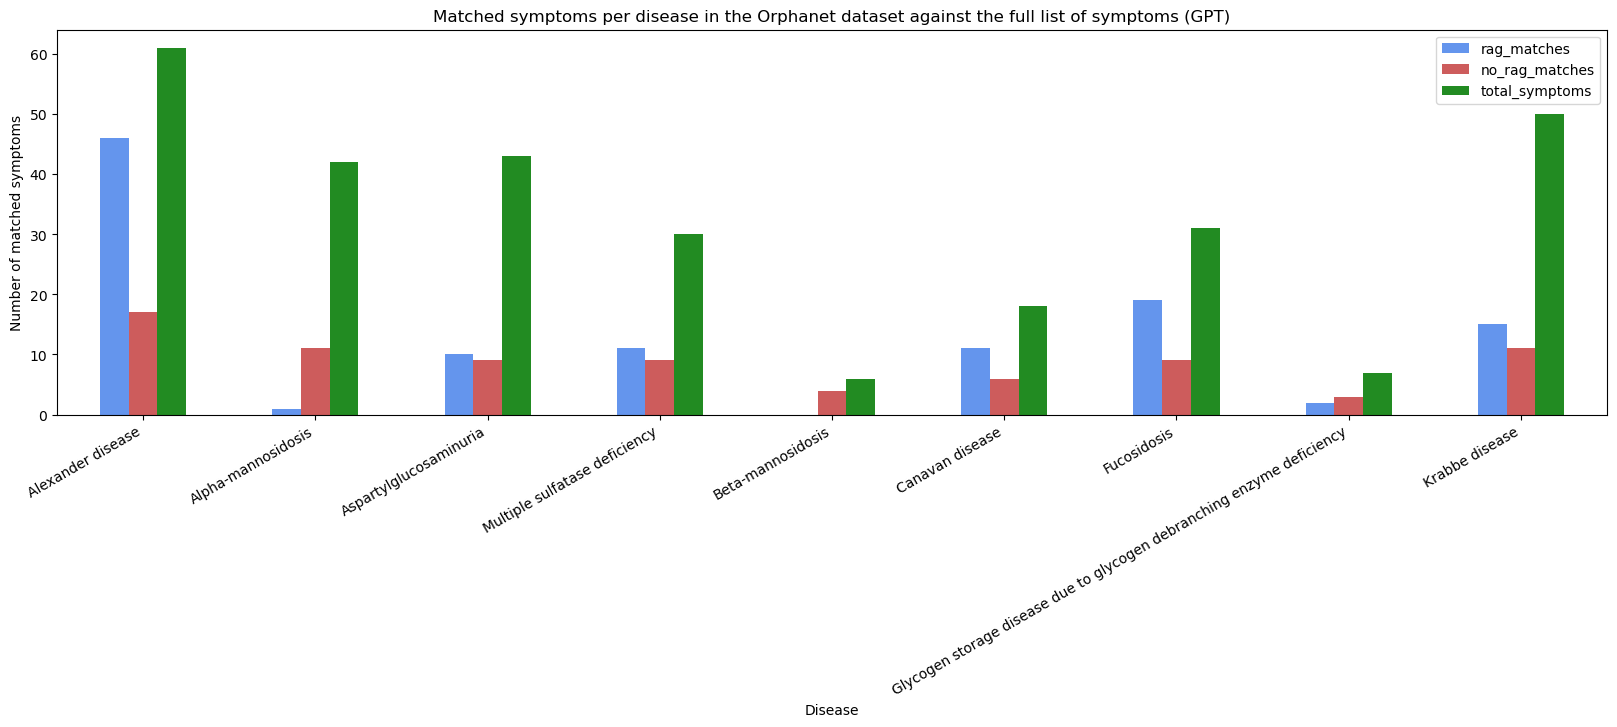

In [73]:
gpt_data.plot(
    x="disease",
    y=["rag_matches", "no_rag_matches", "total_symptoms"],
    kind="bar",
    color=["cornflowerblue", "indianred", "forestgreen"],
    title="Matched symptoms per disease in the Orphanet dataset against the full list of symptoms (GPT)",
    ylabel="Number of matched symptoms",
    xlabel="Disease",
    figsize=(20, 5),
)
plt.xticks(rotation=30, ha='right')
plt.show()

In [74]:
gpt_matches_percentage_orpha = gpt_data['no_rag_matches'].sum() / gpt_data['total_symptoms'].sum() * 100 if gpt_data['total_symptoms'].sum() > 0 else 0
rag_gpt_percentage_orpha = gpt_data['rag_matches'].sum() / gpt_data['total_symptoms'].sum() * 100 if gpt_data['total_symptoms'].sum() > 0 else 0

gpt_summary_df = pd.DataFrame({
    "Model": ["RAG", "ChatGPT"],
    "Orphanet (all symptoms)": [f"{round(rag_gpt_percentage_orpha, 2)} %", f"{round(gpt_matches_percentage_orpha, 2)} %"],
})
gpt_summary_df


,Model,Orphanet (all symptoms)
0,RAG,39.93 %
1,ChatGPT,27.43 %
